In [42]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.functional import softmax
from torch.utils.data import WeightedRandomSampler


import rasterio
from rasterio.windows import Window
from tqdm import tqdm

import numpy as np
import random

from collections import Counter

In [77]:
stacked_raster_path = 'data/Clipped_rasters/stacked_NAIP2019_CHM.tif'
label_raster_path = 'data/classification_polys/training_labels.tif'


In [78]:
print(torch.cuda.is_available())          # should be True
print(torch.cuda.get_device_name(0))      # should say RTX 4070


True
NVIDIA GeForce RTX 4070 Ti SUPER


In [79]:
def extract_patches_from_rasters(stacked_raster_path, label_raster_path, patch_size=128, stride=128):

    # Load stacked raster
    with rasterio.open(stacked_raster_path) as src:
        stacked = src.read()  # shape: (bands, rows, cols)
        height, width = src.height, src.width

    # Load label raster
    with rasterio.open(label_raster_path) as src:
        labels = src.read(1)  # shape: (rows, cols)

    img_patches = []
    label_patches = []

    # Slide window over raster
    for row in range(0, height - patch_size + 1, stride):
        for col in range(0, width - patch_size + 1, stride):
            img_patch = stacked[:, row:row + patch_size, col:col + patch_size]
            label_patch = labels[row:row + patch_size, col:col + patch_size]

            # Sanity check: skip incomplete patches at the edges (if needed)
            if img_patch.shape[1:] != (patch_size, patch_size):
                continue

            img_patches.append(img_patch)
            label_patches.append(label_patch)

    # Convert lists to NumPy arrays
    X = np.stack(img_patches)     # shape: (N, bands, H, W)
    y = np.stack(label_patches)   # shape: (N, H, W)

    print(f"Extracted {X.shape[0]} patches of size {patch_size}×{patch_size}")
    return X, y

X_patches, y_patches = extract_patches_from_rasters(
    stacked_raster_path,
    label_raster_path,
    patch_size=128,
    stride=128
)


Extracted 864 patches of size 128×128


In [80]:
class RasterPatchDataset(Dataset):
    def __init__(self, X, y, normalize=True, augment=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.normalize = normalize
        self.augment = augment

        if self.normalize:
            self.X = self._normalize(self.X)

    def _normalize(self, x):
        x_min = x.min(axis=(2, 3), keepdims=True)
        x_max = x.max(axis=(2, 3), keepdims=True)
        return (x - x_min) / (x_max - x_min + 1e-5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.augment:
            x, y = self._augment(x, y)

        return torch.tensor(x), torch.tensor(y)

    def _augment(self, x, y):
        # Random horizontal flip
        if random.random() > 0.5:
            x = np.flip(x, axis=2)
            y = np.flip(y, axis=1)

        # Random vertical flip
        if random.random() > 0.5:
            x = np.flip(x, axis=1)
            y = np.flip(y, axis=0)

        # Random rotation
        k = random.choice([0, 1, 2, 3])
        x = np.rot90(x, k, axes=(1, 2)).copy()
        y = np.rot90(y, k, axes=(0, 1)).copy()

        # Brightness drop (simulate shadow)
        if random.random() > 0.7:
            factor = random.uniform(0.6, 0.9)
            x *= factor
            x = np.clip(x, 0, 1)

        # Gaussian noise
        if random.random() > 0.7:
            noise = np.random.normal(0, 0.02, x.shape)
            x += noise
            x = np.clip(x, 0, 1)

        return x, y

In [81]:
# Count class frequencies in the label patches
class_counts = Counter()
for patch in y_patches:
    unique, counts = np.unique(patch[patch != 255], return_counts=True)
    class_counts.update(dict(zip(unique, counts)))

# Inverse class weights
total = sum(class_counts.values())
class_weights = {cls: total / count for cls, count in class_counts.items()}

# Assign a weight to each patch based on the rarest class in it
patch_weights = []
for patch in y_patches:
    labels = np.unique(patch[patch != 255])
    if len(labels) == 0:
        patch_weights.append(0)
    else:
        patch_weights.append(max([class_weights.get(lbl, 0) for lbl in labels]))

patch_weights = np.array(patch_weights)
patch_weights = patch_weights / patch_weights.sum()  # normalize

# 2️⃣ Then pass the sampler to your DataLoader:
dataset = RasterPatchDataset(X_patches, y_patches, normalize=True, augment=True)
sampler = WeightedRandomSampler(weights=patch_weights, num_samples=len(patch_weights), replacement=True)
dataloader = DataLoader(dataset, batch_size=8, sampler=sampler)

In [82]:
class UNet(nn.Module):
    def __init__(self, in_channels=5, n_classes=4):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        out = self.out_conv(d1)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
# Use your existing model, device, and dataset
model = UNet(in_channels=5, n_classes=9).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = Adam(model.parameters(), lr=1e-4)

# Wrap patch data in a PyTorch Dataset and DataLoader
dataset = RasterPatchDataset(X_patches, y_patches)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

n_epochs = 150

best_loss = float('inf')

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Skip empty-label patches
        if (y_batch != 255).sum() == 0:
            continue

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f}")

    # ✅ Save the best model so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "data/models/habitat_unet.pth")
        print("Saved new best model")


Epoch 1/150 — Loss: 1.4468
Saved new best model
Epoch 2/150 — Loss: 0.9416
Saved new best model
Epoch 3/150 — Loss: 0.8584
Saved new best model
Epoch 4/150 — Loss: 0.8577
Saved new best model
Epoch 5/150 — Loss: 0.6910
Saved new best model
Epoch 6/150 — Loss: 0.6522
Saved new best model
Epoch 7/150 — Loss: 0.5444
Saved new best model
Epoch 8/150 — Loss: 0.5218
Saved new best model
Epoch 9/150 — Loss: 0.5348
Epoch 10/150 — Loss: 0.3916
Saved new best model
Epoch 11/150 — Loss: 0.4529
Epoch 12/150 — Loss: 0.4335
Epoch 13/150 — Loss: 0.3268
Saved new best model
Epoch 14/150 — Loss: 0.3387
Epoch 15/150 — Loss: 0.3075
Saved new best model
Epoch 16/150 — Loss: 0.2678
Saved new best model
Epoch 17/150 — Loss: 0.3303
Epoch 18/150 — Loss: 0.3374
Epoch 19/150 — Loss: 0.3389
Epoch 20/150 — Loss: 0.3690
Epoch 21/150 — Loss: 0.2122
Saved new best model
Epoch 22/150 — Loss: 0.2636
Epoch 23/150 — Loss: 0.2948
Epoch 24/150 — Loss: 0.1886
Saved new best model
Epoch 25/150 — Loss: 0.2717
Epoch 26/150 — 

In [84]:
# --- Load model ---
model = UNet(in_channels=5, n_classes=9).to(device)
model.load_state_dict(torch.load("data/models/habitat_unet.pth", map_location=device))
model.eval()

# --- Settings ---
tile_size = 1024
overlap = 128  # adjust for smoother edge transitions
stride = tile_size - overlap

# --- Normalize function ---
def normalize_patch(x):
    x_min = x.min(axis=(0, 1), keepdims=True)
    x_max = x.max(axis=(0, 1), keepdims=True)
    return (x - x_min) / (x_max - x_min + 1e-5)

# --- Initialize output raster ---
with rasterio.open(stacked_raster_path) as src:
    profile = src.profile.copy()
    width, height = src.width, src.height
    transform = src.transform
    crs = src.crs
    full_prediction = np.zeros((height, width), dtype=np.uint8)

    # --- Sliding window prediction ---
    for y in tqdm(range(0, height, stride)):
        for x in range(0, width, stride):
            win_width = min(tile_size, width - x)
            win_height = min(tile_size, height - y)

            win = Window(x, y, win_width, win_height)
            img = src.read(window=win).astype(np.float32)  # shape: (bands, h, w)

            # Normalize
            img = np.transpose(img, (1, 2, 0))  # (h, w, bands)
            img = normalize_patch(img)
            img = np.transpose(img, (2, 0, 1))  # (bands, h, w)

            # Convert to torch and pad
            tensor = torch.tensor(img).unsqueeze(0).to(device)
            _, _, h, w = tensor.shape
            pad_h = (16 - h % 16) % 16
            pad_w = (16 - w % 16) % 16
            tensor = F.pad(tensor, (0, pad_w, 0, pad_h), mode='reflect')

            # Predict
            with torch.no_grad():
                out = model(tensor)
                pred = torch.argmax(out, dim=1).squeeze().cpu().numpy()
                pred = pred[:h, :w]
            
            # Mask out pixels where all bands were zero BEFORE normalization
            zero_mask = np.all(img == 0, axis=0)  # shape: (h, w)
            pred[zero_mask] = 255  # or whatever you use for nodata

            # Store masked prediction
            full_prediction[y:y+h, x:x+w] = pred

profile.update({
    'count': 1,
    'dtype': 'uint8',
    'compress': 'lzw',
    'nodata': 255
})

output_path = "data/output/predicted_classes_dl_9.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(full_prediction, 1)

print(f"✅ Saved prediction to {output_path}")

C:\Users\tjwil\AppData\Local\Temp\ipykernel_7844\3142628153.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("data/models/habitat_unet.pt

✅ Saved prediction to data/output/predicted_classes_dl_9.tif


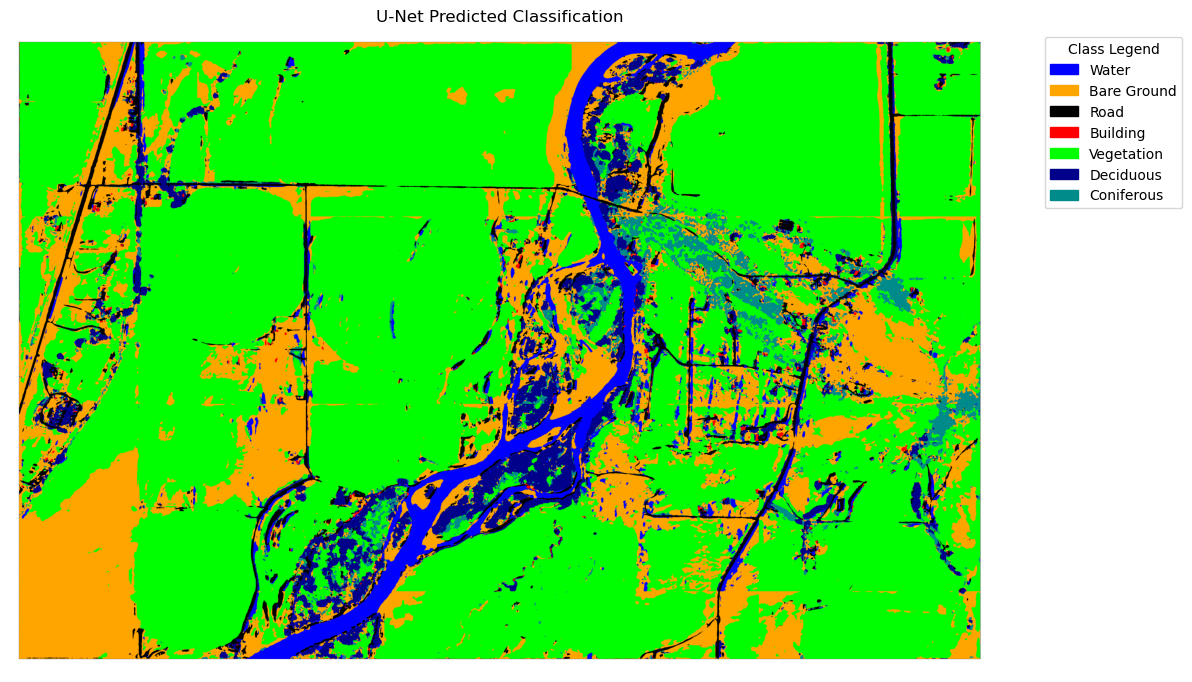

In [85]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# --- Load U-Net output raster ---
with rasterio.open(output_path) as src:
    unet_pred = src.read(1)

# --- Define class color scheme (same as RF legend) ---
class_info = {
    0: ("Water", "#0000FF"),
    1: ("Bare Ground", "#FFA500"),      # includes original Gravel
    2: ("Road", "#000000"),
    3: ("Building", "#FF0000"),
    4: ("Vegetation", "#00FF00"),       # merged Crop + Non-crop Vegetation
    5: ("Deciduous", "#00008B"),
    6: ("Coniferous", "#008B8B"),
}

labels_sorted = sorted(class_info.keys())
colors = [class_info[i][1] for i in labels_sorted]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(len(colors) + 1) - 0.5, cmap.N)

# --- Mask nodata (255) ---
masked = np.ma.masked_where(unet_pred == 255, unet_pred)

# --- Plot ---
plt.figure(figsize=(12, 10))
plt.imshow(masked, cmap=cmap, norm=norm)
plt.title("U-Net Predicted Classification")
plt.axis('off')

# --- Add legend ---
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for (label, color) in [class_info[i] for i in labels_sorted]
]
plt.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title="Class Legend"
)

plt.tight_layout()
plt.show()
